## Generate waypoints for flightlines from line Shapefile

#### Importing some libraries, and other preparations, for later use

**NOTE: The following libraries are not in the Python standard library and need to be installed using `pip` or `conda`, or whichever package management system you use.**

In [99]:
import os
import fiona
import geopandas as gp
from shapely.geometry import LineString

### Read and inspect shapefile

Enter Shapefile path and prefix to use for waypoints.

In [160]:
shapefile = gp.read_file("SHP/CPCRW/CPCRW_flightlines.shp")
prefix = 'CPC'

The following plot should show **lines**. If the Shapefile does not contain lines, the rest of this notebook cannot directly be applied. 

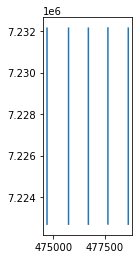

In [161]:
ax = shapefile.plot()
ax.set_aspect('equal')

For use in GPS, the data has to be in WGS84 lat/lon. This is EPSG:4326. We reproject if necessary. 

In [162]:
shapefile_latlon = shapefile
shapefile.crs

<Projected CRS: EPSG:32606>
Name: WGS 84 / UTM zone 6N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 150°W to 144°W - by country
- bounds: (-150.0, 0.0, -144.0, 84.0)
Coordinate Operation:
- name: UTM zone 6N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [163]:
shapefile_latlon = shapefile.to_crs(epsg=4326)

In [164]:
shapefile_latlon.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Extract endpoints from each flightlien

In [165]:
shapefile_latlon['points'] = shapefile_latlon.apply(lambda x: [y for y in x['geometry'].boundary], axis=1)

In [166]:
shapefile_latlon

,Id,geometry,points
0,0,"LINESTRING (-147.49824 65.21203, -147.49664 65...","[POINT (-147.4982432859364 65.21203166853229),..."
1,0,"LINESTRING (-147.51869 65.21196, -147.51702 65...","[POINT (-147.5186882402178 65.21196252521337),..."
2,0,"LINESTRING (-147.47809 65.21218, -147.47655 65...","[POINT (-147.4780862500085 65.21218238798522),..."
3,0,"LINESTRING (-147.45710 65.21216, -147.45564 65...","[POINT (-147.4571036684693 65.21216237546902),..."
4,0,"LINESTRING (-147.54088 65.21188, -147.53914 65...","[POINT (-147.5408796616118 65.21188432719819),..."


In [167]:
endpointlist = [ pt for flightline in shapefile_latlon['geometry'] for pt in flightline.boundary]
endpoints = gp.GeoSeries(endpointlist)

### Re-order endpoints

The endpoints are likely to be in the wrong order for use in in-flight GPS. In this section we can inspect and re-order.

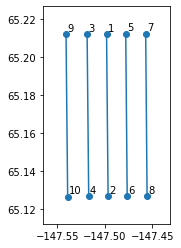

In [168]:
ax = endpoints.plot()
shapefile_latlon.plot(ax=ax)
ax.set_aspect(2)
bottom, top = ax.get_ylim()
left, right = ax.get_xlim()
ax.set_ylim(bottom - 0.01, top + 0.01)
ax.set_xlim(left - 0.02, right + 0.02)
for idx, pt in enumerate(endpoints):
    ax.annotate(str(idx+1), xy=(pt.x, pt.y), xytext=(1, 3), textcoords="offset points")

Enter a list using the above indices in the desired order. 

In [169]:
neworder = [9, 10, 4, 3, 1, 2, 6, 5, 7, 8]

########### validation ####################
if (len(neworder) != len(endpointlist) or set(neworder) != set(list(range(1, len(endpointlist)+1)))):
    raise Exception(f"The neworder variable must be a permutation of {str(list(range(1, len(endpointlist)+1)))}")

### Visualize and export new points as GPX file

In [170]:
newpointlist = [endpointlist[ii-1] for ii in neworder ]
newpoints = gp.GeoSeries(newpointlist)
flightconnector = gp.GeoSeries(LineString(newpointlist))

The following is to check that the new order of flightline endpoints is as desired. If not, return to the previous step. 

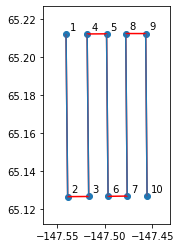

In [171]:
ax = newpoints.plot()
flightconnector.plot(ax=ax, color='r')
shapefile_latlon.plot(ax=ax)
ax.set_aspect(2)
bottom, top = ax.get_ylim()
left, right = ax.get_xlim()
ax.set_ylim(bottom - 0.01, top + 0.01)
ax.set_xlim(left - 0.02, right + 0.02)
for idx, pt in enumerate(newpoints):
    ax.annotate(str(idx+1), xy=(pt.x, pt.y), xytext=(4, 4), textcoords="offset points")


In [172]:
def get_flightcoords(pointlist, prefix=prefix):
    return [(f"{prefix}{str(ii).zfill(2)}", pt.y, pt.x)
             for ii, pt in enumerate(pointlist)]
get_flightcoords(newpointlist)

[('CPC00', 65.21188432719819, -147.5408796616118),
 ('CPC01', 65.12643046214588, -147.53914341445014),
 ('CPC02', 65.12650835627535, -147.51702331577795),
 ('CPC03', 65.21196252521337, -147.5186882402178),
 ('CPC04', 65.21203166853229, -147.4982432859364),
 ('CPC05', 65.12657723090261, -147.49664407199455),
 ('CPC06', 65.1267276970154, -147.47655181600533),
 ('CPC07', 65.21218238798522, -147.47808625000846),
 ('CPC08', 65.21216237546902, -147.4571036684693),
 ('CPC09', 65.12670742995422, -147.45563668051724)]

In [173]:
def get_gpx(flightpoints):

    ele = 0
    gpx_prefix = """<?xml version="1.0" encoding="utf-8" standalone="yes"?>
    <gpx version="1.1" creator="Alaska EPSCoR Fire and Ice https://epscor.alaska.edu/" xmlns="http://www.topografix.com/GPX/1/1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd">
    """
    gpx_suffix = "</gpx>"
    gpx_output = [gpx_prefix]

    for wptname, lat, lon in flightpoints:
        gpx_item = f"""<wpt lat="{lat}" lon="{lon}">
      <ele>{ele}</ele>
      <name>{wptname}</name>
    </wpt>"""
        gpx_output.append(gpx_item)
    gpx_output.append(gpx_suffix)
    return gpx_output

In [174]:
gpx_output = get_gpx(get_flightcoords(newpointlist))
print('\n'.join(gpx_output))

<?xml version="1.0" encoding="utf-8" standalone="yes"?>
    <gpx version="1.1" creator="Alaska EPSCoR Fire and Ice https://epscor.alaska.edu/" xmlns="http://www.topografix.com/GPX/1/1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd">
    
<wpt lat="65.21188432719819" lon="-147.5408796616118">
      <ele>0</ele>
      <name>CPC00</name>
    </wpt>
<wpt lat="65.12643046214588" lon="-147.53914341445014">
      <ele>0</ele>
      <name>CPC01</name>
    </wpt>
<wpt lat="65.12650835627535" lon="-147.51702331577795">
      <ele>0</ele>
      <name>CPC02</name>
    </wpt>
<wpt lat="65.21196252521337" lon="-147.5186882402178">
      <ele>0</ele>
      <name>CPC03</name>
    </wpt>
<wpt lat="65.21203166853229" lon="-147.4982432859364">
      <ele>0</ele>
      <name>CPC04</name>
    </wpt>
<wpt lat="65.12657723090261" lon="-147.49664407199455">
      <ele>0</ele>
      <name>CPC05</name>
    </

In [175]:
filename = f'{prefix}_2020_SP.gpx'
outpath = os.path.join('output/', filename)
with open(outpath, 'w') as dst:
    dst.write('\n'.join(gpx_output))